In [1]:
# Importing packages
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
import csv

In [2]:
# Functions to load and show images
def load_data(file_path):
    image = Image.open(file_path)
    return image

def show_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [3]:
# Loading a test image
test1 = load_data("images/vatican.png")
test1.size

(920, 1404)

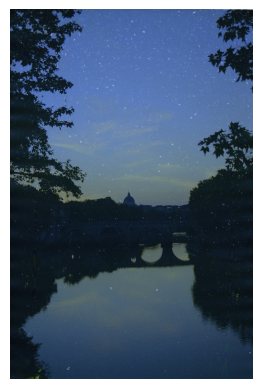

In [4]:
show_image(test1)

In [5]:
# Resize the input image
def resize(image, max_size):
    '''
    Resize the input image to match a maximum dimension while maintaining the aspect ratio.
    :Param image: input image to be resized, opened using the load_data function
    :Param max_size: (width, height) maximum desired dimensions
    :Return the resized image
    '''
    image.thumbnail(max_size, Image.LANCZOS)
    return image
# Thumbnail method adjusts the image in place

In [6]:
test1_resize = resize(test1, (500, 1000))
test1_resize.size

(500, 763)

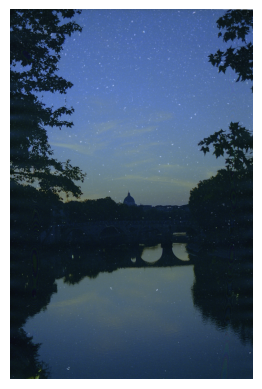

In [7]:
show_image(test1_resize)

In [8]:
# Color reduction method options
def kmeans_reduction(image, num_colors):
    '''
    Use KMeans to reduce the number of unique colors in an image represented by an array
    :Param image: Resized image you want to have reduce the number of colors for
    :Param num_colors: Desired number of unique colors
    Return Labels for each pixel and the palette of the identified colors
    '''    
    kmeans = KMeans(n_clusters=num_colors, random_state=18, n_init=15).fit(image)
    labels = kmeans.labels_
    palette = kmeans.cluster_centers_
    return labels, palette

def meanshift_reduction(image_array, num_colors):
    """
    Reduce the number of colors using Mean Shift clustering.
    :Param image_array: Flattened array representation of the image
    :Param num_colors: Number of unique colors to reduce to
    :Return: Labels for each pixel and the palette of reduced colors
    """
    bandwidth = estimate_bandwidth(image_array, quantile=0.2, n_samples=500)
    meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(image_array)
    labels = meanshift.labels_
    palette = meanshift.cluster_centers_
    return labels, palette

def gmm_reduction(image_array, num_colors):
    """
    Reduce the number of colors using Gaussian Mixture Model (GMM) clustering.
    :Param image_array: Flattened array representation of the image
    :Param num_colors: Number of unique colors to reduce to
    :Return: Labels for each pixel and the palette of reduced colors
    """
    gmm = GaussianMixture(n_components=num_colors, random_state=18).fit(image_array)
    labels = gmm.predict(image_array)
    palette = gmm.means_
    return labels, palette


In [9]:
# Broken up color reduction
def color_reduction(image, method, num_colors):
    '''
    Reduce the number of colors using K-means clustering.
    :Param image: input image for color manipulation, pre-processed using the resize function
    :Param num_colors: How many unique colors you want to work with
    :Return an image composed of only the specified number of colors
    '''
    image_array = np.array(image)
    height, width, channels = image_array.shape
    image_array = image_array.reshape(-1, channels)

    if method == 'kmeans':
        labels, palette = kmeans_reduction(image_array, num_colors)
    elif method == 'meanshift':
        labels, palette = meanshift_reduction(image_array, num_colors)
    elif method == 'gmm':
        labels, palette = gmm_reduction(image_array, num_colors)
    else:
        raise ValueError("Unsupported method. Please chose from 'kmeans', 'meanshift', or 'gmm'.")

    mapped_colors = palette[labels].reshape(height, width, channels).astype('uint8')
    return Image.fromarray(mapped_colors), labels.reshape(height, width), palette

In [10]:
#test1_color = color_reduction(test1_resize, 7)
test1_color18, test1_labels, test1_palette = color_reduction(test1_resize, 'kmeans', 18)

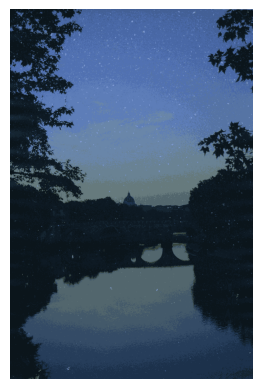

In [11]:
show_image(test1_color18)

In [12]:
# Creating the pattern
def create_pattern(image):
    '''
    Converting the color reduced image to a cross stitch pattern in the form of a numpy array
    :Param image: resized and color reduced image that needs to be converted to a pattern
    :Return: Numpy array of the pattern
    '''
    pattern = np.array(image)
    return pattern

In [13]:
test1_pattern = create_pattern(test1_color18)

In [14]:
# Mapping colors to numbers
def symbol_mapping(palette):
    '''
    Create a mapping from colors to symbols/labels
    :Param palette: list of unique colors generated by the color reduction process
    :Returns a map from color to labels
    '''
    mapping = {}
    for i, color in enumerate(palette):
        mapping[tuple(color)] = str(i + 1)
    return mapping

In [15]:
# Translating the patterns to a csv
def pattern_to_csv(labels, palette, csv_path):
    '''
    Creating a csv file representing the cross-stitch pattern
    :Param labels: list of color labels produced by the color_reduction algorithm
    :Param palette: color palette developed by the color_reduction function
    :Param csv_path: File path of where you want the cross stitch pattern CSV to be saved
    :Return csv file representing the cross-stitch pattern
    '''
    color_to_symbol = symbol_mapping(palette)
    height, width = labels.shape
    with open(csv_path, mode = 'w', newline='') as file:
        writer = csv.writer(file)
        for i in range(height):
            row = [color_to_symbol[tuple(palette[labels[i, j]])] for j in range(width)]
            writer.writerow(row)

In [16]:
# Putting it all together!
def image_to_cross_stitch(file_path, max_size, num_colors, method, csv_path):
    '''
    Convering an image file to a cross-stitch pattern and then saving it as a csv
    :Param file_path: Path to image you want to turn into a cross-stitch pattern
    :Param max_size: (width, height) Desired dimensions for the final pattern
    :Param num_colors: Number of unique colors desired for the final pattern
    :Param method: Method specification for the color reduction algorithm
    :Param csv_path: path to save the final CSV file
    :Returns a CSV file representing the image's cross-stitch pattern
    '''
    image = load_data(file_path)
    resized = resize(image, max_size)
    color_reduced, labels, palette = color_reduction(resized, method, num_colors)
    pattern = create_pattern(color_reduced)

    pattern_to_csv(labels, palette, csv_path)
    print(f"Pattern is saved to {csv_path}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(resized)
    plt.title('Resized')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(color_reduced)
    plt.title('Color Reduced')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Pattern is saved to vatican.csv


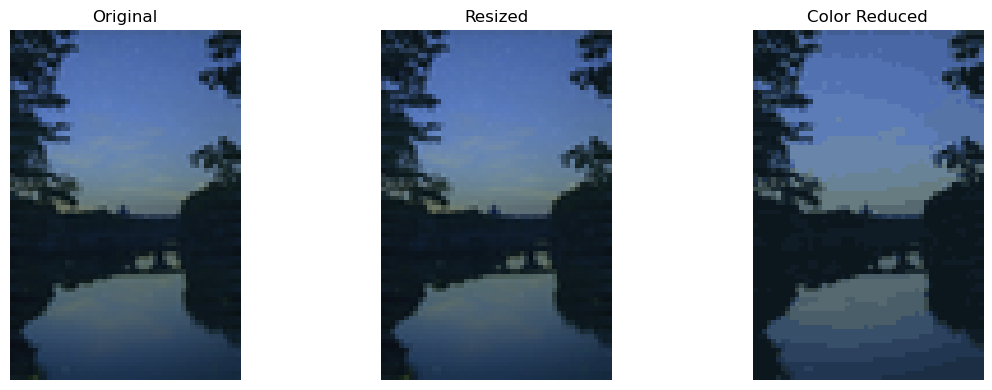

In [17]:
image_to_cross_stitch("images/vatican.png", (50, 100), 18, 'kmeans', "vatican.csv")